# VGG-16 model

In [1]:
from keras.applications import vgg16
from keras.models import Model
import keras

Using plaidml.keras.backend backend.


In [2]:
batch_size = 30
epochs = 30
input_shape = (150, 150, 3)

In [3]:
import import_ipynb
from Dataset_utils import get_imgs_scaled, get_labels_enc

train_imgs_scaled, validation_imgs_scaled = get_imgs_scaled()
train_labels_enc, validation_labels_enc = get_labels_enc()

importing Jupyter notebook from Dataset_utils.ipynb


In [4]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

INFO:plaidml:Opening device "opencl_amd_hainan.0"


In [5]:
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

In [6]:
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

c:\users\darsh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000002C3DE2AF0C8>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x000002C3F2E3FA48>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x000002C3F2E3FBC8>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x000002C3FFBFFAC8>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x000002C3DE41B148>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x000002C3DF190948>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x000002C3FFBD0388>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x000002C3DF1AC9C8>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x000002C3F2E1A288>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x000002C3DF1ACFC8>,block3_conv3,False


(1, 4, 4, 512)


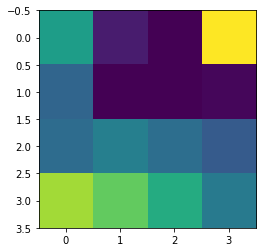

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [8]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [9]:
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (1000, 8192)


In [10]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

In [11]:
input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 9s 3ms/step - loss: 0.4180 - acc: 0.7970 - val_loss: 0.3339 - val_acc: 0.8510
Epoch 2/30
3000/3000 [==============================] - 3s 1ms/step - loss: 0.2870 - acc: 0.8773 - val_loss: 0.3338 - val_acc: 0.8580
Epoch 3/30
3000/3000 [==============================] - 3s 1ms/step - loss: 0.2348 - acc: 0.9013 - val_loss: 0.2706 - val_acc: 0.8850
Epoch 4/30
3000/3000 [==============================] - 3s 1ms/step - loss: 0.1996 - acc: 0.9130 - val_loss: 0.3561 - val_acc: 0.8460
Epoch 5/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1656 - acc: 0.9297 - val_loss: 0.3395 - val_acc: 0.8580
Epoch 6/30
3000/3000 [==============================] - 3s 1ms/step - loss: 0.1538 - acc: 0.9353 - val_loss: 0.3818 - val_acc: 0.8510
Epoch 7/30
3000/3000 [==============================] - 3s 1ms/step - loss: 0.1177 - acc: 0.9507 - val_loss: 0.3191 - val_acc: 0.8750
Epoch 8/30
300

In [15]:
# save model
import os

if(not os.path.exists('saved_models')):
    os.mkdir('saved_models')
model.save('saved_models/pre_trained_tlearn.h5')

In [16]:
# save history
import pickle
import os

if(not os.path.exists('saved_history')):
    os.mkdir('saved_history')
f = open('saved_history/pre_trained_tlearn.pckl', 'wb')
pickle.dump(history.history, f)
f.close()

In [17]:
# load history
import pickle

file = 'saved_history/pre_trained_tlearn.pckl'
f = open(file, 'rb')
hist = pickle.load(f)
f.close()

importing Jupyter notebook from model_summary.ipynb


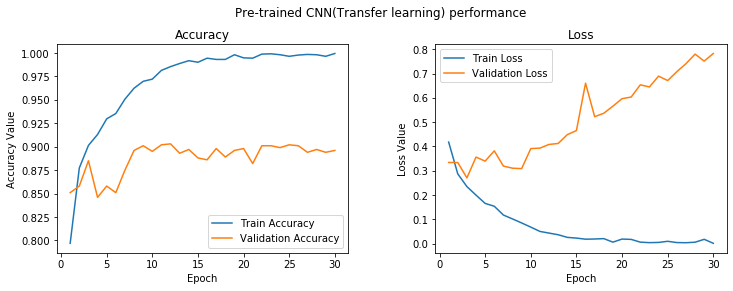

In [18]:
# plot graph
import import_ipynb
from model_summary import plot_graph

performance = 'Pre-trained CNN(Transfer learning) performance'
plot_graph(performance, hist, 30)